# Async Task Processing in Ray Serve

## Problem Statement

Ray Serve customers need a way to handle long-running API requests asynchronously. For example, when a user requests video or document indexing, the system should enqueue the task in a background queue for later processing. The API should return a quick response while the task executes asynchronously.

## Traditional Solution and Its Challenges

A common approach is to use a message broker to queue tasks and a stream processor to handle them asynchronously. However, this introduces complexity for customers who lack the infrastructure for online stream processing, requiring them to manage and scale additional components.

If image dont show up see `stream_processor.png`.
<img src="stream_processor.png" width="800" />

## Proposed Solution

For Anyscale customers using Ray Serve, we propose hosting **Celery Workers as Ray Serve Deployments**. Since Celery supports various message brokers (e.g., SQS, Redis, RabbitMQ), users can bring their own message brokers for async task queuing.

This approach slightly deviates from Ray Serve’s original request-response model by enabling it to support long-running stream processing applications.

If image dont show up see `serve_stream_processor.png`.
<img src="serve_stream_processor.png" width="800" />


## Alternatives Considered

1. **Using Ray Tasks within a Deployment Handler**  

```python
indexing_worker.remote(video_id, "https://www.youtube.com/watch?v=dQw4w9WgXcQ")
```

While Ray is designed for distributed task execution, this approach fails because the indexing_worker task would share fate with the MyApp deployment. During service rollouts, Ray's garbage collection may cancel in-progress tasks.

2. **Building a Custom Stream Processor**

Developing a custom solution to support multiple message brokers would require significant effort. Celery already provides this functionality, making it the better choice.

## Current Status
Support for Celery within Ray Serve is experimental, and recommendations may evolve. This document serves as an initial exploration of the approach.

In [1]:
import asyncio
import json
import threading
import time
import uuid
from celery import Celery
from fastapi import FastAPI, Request
from ray import serve
import ray
import redis
import requests
import numpy as np
import matplotlib.pyplot as plt
import inspect
from ray.serve.handle import DeploymentHandle

import logging
logging.disable(logging.NOTSET)

## What's Covered in This Notebook

1. **Start Redis Server**  
   - Set up a Redis instance to act as the message broker for Celery.

2. **Define Two Ray Serve Applications**  
   - **`IndexingTasksDeployment`**: Runs Celery workers and contains user-defined tasks. This inherits from serve provided `CeleryWorkerDeployment` class.
   - **`MyApp`**: The main Ray Serve application that handles user facing API requests.

3. **Deploy and Demonstrate Async Task Processing**  
   - Deploy both applications within a single Ray Serve deployment.  
   - Show how routes in `MyApp` can enqueue tasks in Celery for asynchronous execution.


## Start Redis

In our example we are using redis for both data broker and backend. In real world they can be different and both should be provided by the user.

In [2]:
!docker run -d --name redis-stack-server -p 6379:6379 redis/redis-stack-server:latest

docker: Error response from daemon: Conflict. The container name "/redis-stack-server" is already in use by container "3d9d3050d37b81325077cf4417083e2bf7b5c100ad60334fb54094e6e4faeabc". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.


In [3]:
redis_client = redis.Redis(host='localhost', port=6379, db=0)

## Define the serve application

In [4]:
ray.init(ignore_reinit_error=True, log_to_driver=False)

2025-03-27 14:25:55,275	INFO worker.py:1843 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 


Python version:,3.11.11
Ray version:,2.44.0
Dashboard:,http://127.0.0.1:8266


In [5]:
fastapi_app = FastAPI()

# Create Celery application
celery_app = Celery(
    'task_queue', 
    broker_url='redis://localhost',
    backend='redis://localhost'
)
celery_app.control.purge()
# prefork is not supported in serve deployment actor because we want the worker (and tasks)
# to be in the same process as the replica actor.
# this means that cpu intensive tasks will block the main thread
configs = {
    'worker_pool': 'threads',
    'worker_concurrency': 10,
}
celery_app.conf.update(configs)

Code in the following cell should go into ray serve as a python module for users to inherit

In [6]:
def task_handler(func):
    func.is_task_handler = True  # Mark the function
    return func

class CeleryWorkerDeployment:
    """
    This is a base class that users will inherit from to create their own celery worker deployments.
    """
    def __init__(self, celery_app: Celery):
        self.celery_app = celery_app
        assert self.celery_app.conf.get('worker_pool') == 'threads', "Only threads pool is supported in serve deployment actor"
        self.celery_worker = celery_app.Worker()
        def run_worker():
            # starting celery worker here so that its part of the same process as the replica actor
            self.celery_worker.start()
        
        # Find and register all methods marked with @task_handler
        for name, method in inspect.getmembers(self, predicate=inspect.ismethod):
            if getattr(method, "is_task_handler", False):
                celery_app.task(method, name=name)
                print(f"Registered task: {name}")
        
        self.celery_worker_thread = threading.Thread(target=run_worker)
        self.celery_worker_thread.start()
    
    def __del__(self):
        # allow the worker to finish all the tasks that are being processed.
        # This does not guarantee that all tasks in the queue are finished.
        print("stopping worker, will wait for all tasks to finish")
        self.celery_worker.stop()
        self.celery_worker_thread.join()

In [7]:
@serve.deployment(
    name="indexing_tasks_deployment",
    num_replicas=5,
)
class IndexingTasksDeployment(CeleryWorkerDeployment):
    """
    This is application code that users will write.
    """
    def __init__(self, celery_app: Celery):
        super().__init__(celery_app)

        # create a large numpy array
        self.arr = np.random.rand(1000000)
        self.redis_client = redis.Redis(host='localhost', port=6379, db=0)

    @task_handler
    def document_indexing_task(self, document_id: str):
        """
        blocking IO operations are allowed here since they are running in a thread from ThreadPoolExecutor
        """

        # set the status to pending
        job = json.loads(self.redis_client.get(document_id))
        job["status"] = "pending"
        self.redis_client.set(document_id, json.dumps(job))

        # task has access to replica actor object because tasks are running in the same process
        # so there is no serialization overhead
        s = np.sum(self.arr)

        # example of making a http request
        # requests.get(f"http://localhost:8000/my_app/index_document_sync?document_id={document_id}").json()

        # example of calling another deployment
        # call the deployment
        return serve.get_app_handle("my_app").index_document.remote(document_id).result()
    

In [8]:
@serve.deployment(
    name="my_app",
    # since celery tasks are calling into `index_document_sync`, set this parameter appropriately.
    max_ongoing_requests=100
)
@serve.ingress(fastapi_app)
class MyApp:
    """
    This is application code that users will write.
    """
    def __init__(self):
        self.redis_client = redis.Redis(host='localhost', port=6379, db=0)

    @fastapi_app.get("/index_document_async")
    def index_document_async(self, document_id: str):

        # async call to celery to enqueue the task
        # task name is the name of the function decorated with @task_handler in the celery worker deployment
        celery_result = celery_app.send_task(name="document_indexing_task", args=(document_id,))

        """
        In order to track the status of the task, the user may choose to make an entry into their own database
        about the request. The idea is that the caller will poll the status of the task from their own database.

        Serve does not provide any built-in support for task status tracking because needs of different users will vary.
        """
        response = {"status": "not_started", "start_time": time.time(), "celery_task_id": celery_result.id}
        self.redis_client.set(document_id, json.dumps(response))
        return response

    @fastapi_app.get("/index_document_sync")
    async def index_document(self, document_id: str):
        """
        This is a heavyweight operation that will be run as part of task processing.
        """
        await asyncio.sleep(5)
        # update the status to done and timestamp and calculate the time taken
        data = json.loads(self.redis_client.get(document_id))
        start_time = data["start_time"]
        end_time = time.time()
        time_taken = end_time - start_time

        data["status"] = "done"
        data["time_taken"] = time_taken
        data["end_time"] = end_time

        self.redis_client.set(document_id, json.dumps(data))
        return f"Document {document_id} indexed in {time_taken} seconds"
    
    @fastapi_app.get("/index_document_status")
    def index_document_status(self, document_id: str):
        """
        Status tracking is left to the user. This is just an example of how to track the status of the task.
        This is just an example of how to track the status of the task, your mileage may vary.
        """

        # get the status from the database, this status is tracked by user. This is probably the most common way users will track the status of the task
        db_status = json.loads(self.redis_client.get(document_id))

        # but if the user wants to track the status of the task in celery, they can do so by calling this endpoint
        # this code exists for demonstration purposes
        celery_result_async = celery_app.AsyncResult(db_status["celery_task_id"])
        if celery_result_async.successful():
            # if the task is still running, calling get will block until the task is finished
            celery_result = celery_result_async.get()
        else:
            celery_result = None

        # return the status
        return {
            "db_status": db_status["status"],
            "celery_status": celery_result_async.status,
            "celery_result": celery_result
        }

task_processor = IndexingTasksDeployment.bind(celery_app)
app = MyApp.bind()


In [9]:
serve.run(app, name="my_app", route_prefix="/my_app")
serve.run(task_processor, name="task_processor", route_prefix="/task_processor")

INFO 2025-03-27 14:25:57,063 serve 83722 -- Started Serve in namespace "serve".
INFO 2025-03-27 14:25:58,178 serve 83722 -- Application 'my_app' is ready at http://127.0.0.1:8000/my_app.
INFO 2025-03-27 14:25:58,182 serve 83722 -- Connecting to existing Serve app in namespace "serve". New http options will not be applied.
INFO 2025-03-27 14:25:59,295 serve 83722 -- Application 'task_processor' is ready at http://127.0.0.1:8000/task_processor.
INFO 2025-03-27 14:25:59,297 serve 83722 -- Started <ray.serve._private.router.SharedRouterLongPollClient object at 0x156e83c10>.


DeploymentHandle(deployment='indexing_tasks_deployment')

## Make async Requests

In [10]:
# create list of 30 document ids
num_tasks = 300
document_ids = [str(uuid.uuid4()) for _ in range(num_tasks)]
# make 30 parallel requests to the task processor
import requests
import threading

def make_request(document_id):
    requests.get(f"http://localhost:8000/my_app/index_document_async?document_id={document_id}")    

threads = []
for document_id in document_ids:
    thread = threading.Thread(target=make_request, args=(document_id,))
    thread.start()
    threads.append(thread)

for thread in threads:
    thread.join()

## Poll for task status

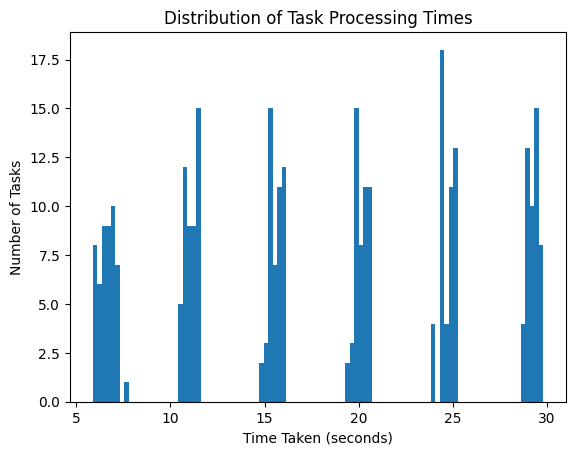

In [11]:
def are_tasks_done(document_ids):
    for document_id in document_ids:
        response = requests.get(f"http://localhost:8000/my_app/index_document_status?document_id={document_id}").json()
        if response["db_status"] != "done":
            return False
    return True

# wait until all tasks are done
while not are_tasks_done(document_ids):
    time.sleep(1)

# plot the time taken for each task add
time_taken = [json.loads(redis_client.get(document_id))["time_taken"] for document_id in document_ids]
plt.hist(time_taken, bins=100)
plt.xlabel('Time Taken (seconds)')
plt.ylabel('Number of Tasks')
plt.title('Distribution of Task Processing Times')
plt.show()


Why did it take **50 seconds** for all tasks to complete?

1. We queued **300 tasks**.  
2. There are **5 Celery workers**, each running with a concurrency of **10** (i.e., **5 × 10 = 50** tasks can run in parallel).  
3. Each task takes **5 seconds** to complete (`time.sleep(5)`).  
4. Since **50 tasks run concurrently**, the total execution time is:  
   $$
   \frac{300 \text{ tasks}}{50 \text{ concurrent workers}} \times 5 \text{ seconds} = 30 \text{ seconds}
   $$
5. As expected, all tasks complete in **30 seconds**.


In [12]:
# get stutus
requests.get(f"http://localhost:8000/my_app/index_document_status?document_id={document_ids[-1]}").json()

{'db_status': 'done',
 'celery_status': 'SUCCESS',
 'celery_result': 'Document 3e05210f-59de-4213-b6ea-bfaca4828eff indexed in 24.985047101974487 seconds'}

In [13]:
# get task status from redis for all tasks count status done
count = 0
pending = 0
not_started = 0
for document_id in document_ids:
    job = json.loads(redis_client.get(document_id))
    if job["status"] == "done":
        count += 1
    elif job["status"] == "pending":
        pending += 1
    else:
        not_started += 1
    
print(f"count of done tasks: {count}, pending tasks: {pending}, not started tasks: {not_started}")

count of done tasks: 300, pending tasks: 0, not started tasks: 0


As you can see from the histogram, all tasks finish around 5 seconds.

## Caveats, Considerations, and Recommendations

1. **Task Delivery Guarantees Depend on the Message Broker**  
   - Different message brokers offer varying guarantees. For example, **SQS provides strong delivery guarantees**, whereas **Redis does not**.  
   - Refer to the [Celery documentation](https://docs.celeryq.dev/en/stable/getting-started/backends-and-brokers/) for broker and backend choices.

2. **At-Least-Once Processing Is Configuration Dependent**  
   - At-least-once processing in Celery depends on configuration parameters like:  
     - `task_acks_late`  
     - `task_acks_on_failure_or_timeout`  
     - `task_publish_retry`  
     - `task_publish_retry_policy`  
   - By default, Celery **does not guarantee at-least-once processing**. See [Celery FAQ](https://docs.celeryq.dev/en/stable/faq.html#faq-acks-late-vs-retry) for details.

3. **TaskProcessor Deployment Should Only Contain Celery Tasks** *(Recommendation, Not a Strict Requirement)*  
   - This simplifies future autoscaling, as task processor scaling can be based purely on queue characteristics.  
   - Mixing API routes in `TaskProcessor` could complicate autoscaling.

4. **Avoid Including TaskProcessor in Deployment Chains**  
   - There is **no need** to include `TaskProcessor` in any deployment chain since Celery tasks are invoked using:  
     ```python
     celery_app.send_task("document_indexing_task", args=(document_id,))
     ```  
   - This remains true until we find a way to support:  
     ```python
     document_indexing_task.delay(document_id)
     ```

5. **Celery Workers Run Inside Ray Actors** *(Key Design Choice)*  
   - Running Celery workers **inside Ray actors** ensures Ray manages their lifecycle, preventing zombie processes if an actor dies.  
   - However, this limits the Celery execution pool to **threads**. See [Celery Worker Pools](https://celery.school/celery-worker-pools) for available options.

6. **Concurrency Considerations**  
   - **For I/O-intensive tasks:** Increase Celery worker concurrency.  
   - **For CPU-intensive tasks:** Increasing thread concurrency **won’t help** due to the **GIL**. Instead, increase `num_replicas` on `TaskProcessor`.

7. **Celery Tasks That Call Other Deployments May Be Bottlenecked**  
   - If a Celery task invokes another Ray Serve deployment, **its concurrency is limited** by the `max_ongoing_requests` of the target deployment.

8. **Status Tracking of Tasks**

When tracking the status of asynchronous tasks queued in Celery, users have two options:  
- **Using Celery Task ID:**  
   Obtain the Celery task ID from `celery_app.send_task` and use `celery_app.AsyncResult(celery_task_id)` to poll for task status.  
- **Custom Status Tracking:**  
   Generate a unique task ID, store it in a database, and update the task status in the database when execution completes.  

The choice between these approaches depends on the application's requirements. Since this falls outside the immediate scope of Ray Serve, we currently do not provide built-in status tracking. However, future support may be considered.

9. **Backward and Forward Compatibility of Tasks During Application Rollouts**

During an **up-then-down** deployment, where two versions of a task processor run concurrently, compatibility issues may arise.  

**Best Practices for Version Rollouts**  
- **Drain Pending Tasks Before Upgrading**  
   Before starting Celery workers with a new application version, ensure that all tasks enqueued by the old version have been processed. If tasks remain in the queue and the new version modifies the task definition incompatibly, they may either:  
     - Remain unprocessed in the queue.  
     - Be incorrectly routed to an unintended task.
   Ray serve does not guard against this, recommendation to user is not make such drastic change to the app. The only thing serve ensures is that, when a deployment actor is shutting down, it will do best effort to stop accepting new tasks and all ongoing tasks are completed before it shuts down.

- **Use Stable Data Serialization**  
   To safeguard against backward and forward compatibility issues, use structured encoding formats like **Protocol Buffers (protobuf)** or **Avro** for task parameters and return values.  

**Task Persistence Considerations**  
The duration a task remains in the queue depends on the **message broker configuration** and whether an `expires` value was set when the task was enqueued. By default, if no workers are available, tasks can sit in the queue indefinitely. This is particularly important when an application rollout **removes a task handler**, as unprocessed tasks may be left in an orphaned state.



---

## Future Work

Currently, this solution is **DIY**, but future improvements should aim for deeper integration:

1. **Move `TaskProcessor` Into Ray Serve**  
   - Reduce boilerplate by abstracting Celery setup from users.

2. **Enable Autoscaling for Celery Workers**  
   - Implement autoscaling based on queue depth and processing load.

3. **Harden the system for failiure conditions**
   - when app rollout, do we loose messages in queue?
   - what happens during replica fail over?

In [14]:
serve.shutdown()
ray.shutdown()